<a href="https://colab.research.google.com/github/Taehee-K/ToBigs15/blob/main/Week9/week9_Advanced%20Models/week9_adv1_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Week 9 과제 1

**잎 사진을 통한 질병 분류**

*   데이터: 21개의 클래스로 구분된 약 20000장의 이미지
><img src="https://drive.google.com/uc?id=1YQkxnNy61Gyi3Gp6ylCKeS72BVruJXr_" width="700" height="500"> 
*   데이터 전처리
    *   전체 데이터를 train,validation,test로 분할해주세요
    *   저는 6:2:2로 분할했는데, 비율은 바꾸셔도 무방합니다.
   
    
*   학습 진행 방향
    *   Baseline 모델(pre-trained model 사용X) 구축
    *   Pre-trained 모델 사용
    *   Baseline과 ResNet50 모델의 성능을 비교해주세요 ~!

In [2]:
# gdrive에 mount
from google.colab import drive
drive.mount('/content/gdrive', force_remount = True)

Mounted at /content/gdrive


In [3]:
# 경로 설정
import os
os.chdir('/content/gdrive/MyDrive/2021/투빅스 정규세션/Week9')

## 0. 데이터 분할

* 데이터 분할을 위한 디렉토리 생성

In [ ]:
import os
import shutil
 
original_dataset_dir = './plant_leaf'   
classes_list = os.listdir(original_dataset_dir) 
 
base_dir = './splitted' 
os.mkdir(base_dir)
 
train_dir = os.path.join(base_dir, 'train') 
os.mkdir(train_dir)
validation_dir = os.path.join(base_dir, 'val')
os.mkdir(validation_dir)
test_dir = os.path.join(base_dir, 'test')
os.mkdir(test_dir)

for cls in classes_list:     
    os.mkdir(os.path.join(train_dir, cls))
    os.mkdir(os.path.join(validation_dir, cls))
    os.mkdir(os.path.join(test_dir, cls))

* 데이터 분할과 클래스별 데이터 수 확인

In [ ]:
import math
 
for cls in classes_list:
    path = os.path.join(original_dataset_dir, cls)
    fnames = os.listdir(path)
 
    train_size = math.floor(len(fnames) * 0.6)
    validation_size = math.floor(len(fnames) * 0.2)
    test_size = math.floor(len(fnames) * 0.2)
    
    train_fnames = fnames[:train_size]
    print("Train size(",cls,"): ", len(train_fnames))
    for fname in train_fnames:
        src = os.path.join(path, fname)
        dst = os.path.join(os.path.join(train_dir, cls), fname)
        shutil.copyfile(src, dst)
        
    validation_fnames = fnames[train_size:(validation_size + train_size)]
    print("Validation size(",cls,"): ", len(validation_fnames))
    for fname in validation_fnames:
        src = os.path.join(path, fname)
        dst = os.path.join(os.path.join(validation_dir, cls), fname)
        shutil.copyfile(src, dst)
        
    test_fnames = fnames[(train_size+validation_size):(validation_size + train_size +test_size)]

    print("Test size(",cls,"): ", len(test_fnames))
    for fname in test_fnames:
        src = os.path.join(path, fname)
        dst = os.path.join(os.path.join(test_dir, cls), fname)
        shutil.copyfile(src, dst)


Train size( Apple___Cedar_apple_rust ):  165
Validation size( Apple___Cedar_apple_rust ):  55
Test size( Apple___Cedar_apple_rust ):  55
Train size( Cherry___Powdery_mildew ):  631
Validation size( Cherry___Powdery_mildew ):  210
Test size( Cherry___Powdery_mildew ):  210
Train size( Corn___healthy ):  697
Validation size( Corn___healthy ):  232
Test size( Corn___healthy ):  232
Train size( Corn___Northern_Leaf_Blight ):  591
Validation size( Corn___Northern_Leaf_Blight ):  197
Test size( Corn___Northern_Leaf_Blight ):  197
Train size( Corn___Common_rust ):  715
Validation size( Corn___Common_rust ):  238
Test size( Corn___Common_rust ):  238
Train size( Cherry___healthy ):  512
Validation size( Cherry___healthy ):  170
Test size( Cherry___healthy ):  170
Train size( Apple___Black_rot ):  372
Validation size( Apple___Black_rot ):  124
Test size( Apple___Black_rot ):  124
Train size( Apple___Apple_scab ):  378
Validation size( Apple___Apple_scab ):  126
Test size( Apple___Apple_scab ): 

## 1. 베이스라인 모델을 구축해 주세요
* Pre-Trained Model을 사용하지 않고 직접 모델을 구축해 주세요 !


In [4]:
original_dataset_dir = './plant_leaf' 
classes_list = os.listdir(original_dataset_dir) 
len(classes_list)

21

In [6]:
import torch
import os
 
if torch.cuda.is_available():
  DEVICE = torch.device('cuda')
else:
  DEVICE = torch.device('cpu')
BATCH_SIZE = 256 
EPOCH = 30 

print(DEVICE)

cuda


In [8]:
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder 
 
transform_base = transforms.Compose([transforms.Resize((64,64)),transforms.ToTensor()]) 
train_dataset = ImageFolder(root='./splitted/train', transform=transform_base) 
val_dataset = ImageFolder(root='./splitted/val', transform=transform_base)

In [9]:
from torch.utils.data import DataLoader

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(val_dataset,batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


* 베이스라인 모델 설계하기

In [10]:
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim
 
class Net(nn.Module): # CNN모델 설계
    def __init__(self): # 클래스 생성시 가지는 성질 정의하는 매서드
        super(Net, self).__init__() # nn.Module 내의 매서드 상속
        self.conv1 = nn.Conv2d( # 1st convolution layer
            in_channels = 3,    # 컬러 이미지 rgb -> 채널 3개
            out_channels = 8,   # 깊이 8인 feature map
            kernel_size = 3,    # 3 x 3 filter
            padding = 1)        # 가장자리 pixel까지 학습하도록 padding 
        self.conv2 = nn.Conv2d( # 1st convolution layer -> feature map과 convolution 하게 됨
            in_channels = 8,    # 앞서 생성된 feature map의 채널 수와 동일
            out_channels = 16,  # 깊이 16인 feature map 생성
            kernel_size = 3,    # 3 x 3 filter
            padding = 1)        # output size = input size 되게끔 padding
        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2) # MaxPool2d -> 2차원 feature map 중 가장 큰 값 이용
        self.fc1 = nn.Linear(16 * 16 * 16, 256)  # 1st fully connected layer
        self.fc2 = nn.Linear(256, 64)  # 2nd fully connected layer
        self.fc3 = nn.Linear(64, 21)  # 3rd fully connected layer -> output 21 개의 질병 분류
    
    def forward(self, x):   # CNN forward propagation
        x = self.conv1(x)   # 첫 번째 convolution-> feature map 생성
        x = F.relu(x)       # feature map에 relu (비선형)
        x = self.pool(x)    # maxpooling -> feature map downsampling
        x = self.conv2(x)   # 두 번째 convolution -> feature map 생성
        x = F.relu(x)       # feature map -> relu 적용
        x = self.pool(x)    # maxpooling

        x = x.view(-1, 16 * 16 * 16)  # 최종 생성된 feature map 1차원 데이터로
        x = self.fc1(x)     # 첫 번째 fully connected layer 적용
        x = F.relu(x)       # relu 적용
        x = self.fc2(x)     # 두 번재 fully connected layer 적용
        x = F.relu(x)       # relu 적용
        x = self.fc3(x)     # 세 번째 fully connected layer 적용

        return F.log_softmax(x, dim=1)  # softmax 통해 최종 output 계산 

model_base = Net().to(DEVICE)  
optimizer = optim.Adam(model_base.parameters(), lr=0.001) 

* 모델 학습을 위한 함수
* 모델 학습, 평가를 위한 가이드라인 코드입니다. 꼭 이 코드를 사용하지는 않으셔도 됩니다 !!

In [11]:
def train(model, train_loader, optimizer):
    model.train() # 앞서 정의한 모델 train 상태로 
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(DEVICE), target.to(DEVICE) # 데이터, 타깃값 DEVICE에 할당
        optimizer.zero_grad() # optimizer gradient 값 초기화
        output = model(data)  # 할당된 데이터로 output 계산
        loss = F.cross_entropy(output, target)  # loss 계산 (Cross Entropy Loss 사용했습니다)
        loss.backward()   # 계산된 loss 값 back propagation
        optimizer.step()  # update parameters

* 모델 평가를 위한 함수

In [12]:
def evaluate(model, test_loader):
    model.eval() # 모델 평가 상태로 
    test_loss = 0 # test_loss 초기화
    correct = 0   # 맞게 예측한 값 0으로 초기화 
    
    with torch.no_grad(): 
        for data, target in test_loader:  
            data, target = data.to(DEVICE), target.to(DEVICE) # data, target DEVICE에 할당
            output = model(data)  # 할당된 데이터로 output 계산

            test_loss += F.cross_entropy(output,target, reduction='sum').item() # loss 계산(총 loss 에 더해주기)

            pred = output.max(1, keepdim=True)[1] # 계산된 벡터값 (크기 21) 중 가장 큰 값 가지는 class 예측   
            correct += pred.eq(target.view_as(pred)).sum().item() # 맞게 예측한 값 세기
   
    test_loss /= len(test_loader.dataset) # 평균 loss
    test_accuracy = 100. * correct / len(test_loader.dataset) # test 데이터 정확도           
                              
    return test_loss, test_accuracy  

* 모델 학습을 실행하기

In [30]:
import time
import copy
 
def train_baseline(model ,train_loader, val_loader, optimizer, num_epochs = 30):
    best_acc = 0.0  # best_accuracy 초기화
    best_model_wts = copy.deepcopy(model.state_dict()) 
 
    for epoch in range(1, num_epochs + 1):
        since = time.time()                                   # 학습 시간 계산
        train(model, train_loader, optimizer)                 # train 데이터로 학습
        train_loss, train_acc = evaluate(model, train_loader) # train_loss, train_acc 계산
        val_loss, val_acc = evaluate(model, val_loader)       # valid_loss, valid_acc 계산
        
        if val_acc>best_acc:  # best_accuracy 업데이트 해주기
            best_acc = val_acc 
            best_model_wts = copy.deepcopy(model.state_dict())
        
        time_elapsed = time.time() - since # 학습 시간 출력
        print('-------------- epoch {} ----------------'.format(epoch))
        print('train Loss: {:.4f}, Accuracy: {:.2f}%'.format(train_loss, train_acc))   
        print('val Loss: {:.4f}, Accuracy: {:.2f}%'.format(val_loss, val_acc))
        print('Completed in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60)) 

    model.load_state_dict(best_model_wts)  # best weights
    return model
 

base = train_baseline(model_base, train_loader, val_loader, optimizer)  # 모델 학습시키기
torch.save(base,'baseline.pt') # 모델 저장
# 최종적으로 train accuracy 93, validation accuracy 88 정도 나왔다

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


-------------- epoch 1 ----------------
train Loss: 1.9125, Accuracy: 40.00%
val Loss: 1.9080, Accuracy: 39.48%
Completed in 0m 59s
-------------- epoch 2 ----------------
train Loss: 1.3565, Accuracy: 55.01%
val Loss: 1.3523, Accuracy: 54.88%
Completed in 0m 58s
-------------- epoch 3 ----------------
train Loss: 1.1181, Accuracy: 64.10%
val Loss: 1.1272, Accuracy: 63.92%
Completed in 0m 59s
-------------- epoch 4 ----------------
train Loss: 0.9462, Accuracy: 68.66%
val Loss: 0.9655, Accuracy: 68.72%
Completed in 0m 59s
-------------- epoch 5 ----------------
train Loss: 0.8129, Accuracy: 72.52%
val Loss: 0.8400, Accuracy: 72.38%
Completed in 0m 60s
-------------- epoch 6 ----------------
train Loss: 0.7803, Accuracy: 73.92%
val Loss: 0.8116, Accuracy: 72.82%
Completed in 0m 59s
-------------- epoch 7 ----------------
train Loss: 0.6558, Accuracy: 78.15%
val Loss: 0.7026, Accuracy: 76.42%
Completed in 0m 59s
-------------- epoch 8 ----------------
train Loss: 0.5958, Accuracy: 80.03%

## 2. Transfer Learning 모델 학습

* Transfer Learning을 위한 준비
* Transfer Learning이 익숙하지 않으신 분들은 PyTorch에서 제공하는 https://9bow.github.io/PyTorch-tutorials-kr-0.3.1/beginner/transfer_learning_tutorial.html 을 참고하세요 :)

In [18]:
data_transforms = { 
    'train': transforms.Compose([           # 데이터 전처리(Augmentation) 진행
        transforms.Resize([64,64]),
        transforms.RandomHorizontalFlip(),  # 50% 확률로 좌우반전 (Random data augmentation은 training set에만 가능하다고 한다)
        # transforms.RandomVerticalFlip(),  # 50% 확률로 상하반전
        transforms.ToTensor(),              # 딥러닝 모델의 input으로 사용하기 위해 Tensor 형태로 변환 
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) ]), # 정규화
    
    'val': transforms.Compose([
        transforms.Resize([64,64]),  
        transforms.ToTensor(),        # 딥러닝 모델의 input으로 사용하기 위해 Tensor 형태로 변환 
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) ]) # 정규화
}

In [19]:
image_datasets = {x: ImageFolder(root = "./splitted", transform = data_transforms[x]) for x in ['train', 'val']} # 데이터 불러오기
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x],        # 불러온 이미지 batch 단위로 구분
                                              batch_size = BATCH_SIZE,  
                                              num_workers = 4, 
                                              shuffle = True) for x in ['train', 'val']}

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


### Pre-Trained Model 불러오기
- 저는 ResNet50을 사용했는데, 코랩 기준으로 다른 ResNet계열이나 DenseNet 정도까지는 큰 무리 없이 훈련할 수 있습니다. Unfreeze layer 수가 적으면 다른 모델도 사용할 수 있을 것입니다.
- 한 가지 모델을 선택해서 Transfer Learning을 해 주세요 !!

In [13]:
from torchvision import models
 
resnet = models.resnet50(pretrained=True)  # resnet50 불러오기, pretrained = True로 학습된 파라미터 값들 불러오기
num_ftrs = resnet.fc.in_features      # resnet50의 fully connected layer의 input 노드 수
resnet.fc = nn.Linear(num_ftrs, 21)   # input 노드 수를 이용해 새로운 layer 추가 -> output 21 개의 질병 분류
resnet = resnet.to(DEVICE)            # resnet 모델 DEVICE에 할당
 
criterion = nn.CrossEntropyLoss() # CrossEntropyLoss 로 loss 계산
optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, resnet.parameters()), lr=0.001) # optimizer -> adam
 
# from torch.optim import lr_scheduler  #scheduler는 사용하지 않으셔도 됩니다 (선택사항)
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)  #7에폭마다 learning rate를 조절하는 역할을 합니다

* Pre-Trained Model의 일부 Layer Freeze하기 (resnet 기준입니다 !!)

In [14]:
ct = 0 
for child in resnet.children():  
    ct+= 1  
    if ct < 6: 
        for param in child.parameters():
            param.requires_grad = False

* Fine Tuning을 진행해주세요 ~!

In [37]:
import time
import copy
 
def train_resnet(model ,train_loader, val_loader, optimizer, num_epochs = 30):
    best_acc = 0.0  
    best_model_wts = copy.deepcopy(model.state_dict()) 
 
    for epoch in range(1, num_epochs + 1):
        since = time.time()  
        train(model, train_loader, optimizer) # train 데이터로 학습
        train_loss, train_acc = evaluate(model, train_loader)
        val_loss, val_acc = evaluate(model, val_loader)
        
        if val_acc>best_acc: 
            best_acc = val_acc 
            best_model_wts = copy.deepcopy(model.state_dict())
        
        time_elapsed = time.time() - since 
        print('-------------- epoch {} ----------------'.format(epoch))
        print('train Loss: {:.4f}, Accuracy: {:.2f}%'.format(train_loss, train_acc))   
        print('val Loss: {:.4f}, Accuracy: {:.2f}%'.format(val_loss, val_acc))
        print('Completed in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60)) 

    model.load_state_dict(best_model_wts)  
    return model

In [44]:
## 기존의 train, validation data set 가지고 resnet 학습
resnet_train = train_resnet(resnet, train_loader, val_loader, optimizer_ft, num_epochs = 25)  # resnet transfer learning 진행
torch.save(resnet_train,'resnet.pt') # 모델 저장
# 최종적으로 train accuracy 100.0%, validation accuracy 99.0% 가 나왔다
# baseline 모델에서는 train accuracy 93.5%, validation accuracy 87.8% 보다 더 높은 성능을 보였다 

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


-------------- epoch 1 ----------------
train Loss: 0.5046, Accuracy: 90.45%
val Loss: 0.5661, Accuracy: 88.98%
Completed in 1m 23s
-------------- epoch 2 ----------------
train Loss: 0.0567, Accuracy: 98.26%
val Loss: 0.0974, Accuracy: 96.95%
Completed in 1m 23s
-------------- epoch 3 ----------------
train Loss: 0.0837, Accuracy: 97.37%
val Loss: 0.1566, Accuracy: 95.38%
Completed in 1m 23s
-------------- epoch 4 ----------------
train Loss: 0.0667, Accuracy: 98.05%
val Loss: 0.1310, Accuracy: 96.14%
Completed in 1m 23s
-------------- epoch 5 ----------------
train Loss: 0.0663, Accuracy: 97.68%
val Loss: 0.1531, Accuracy: 95.64%
Completed in 1m 23s
-------------- epoch 6 ----------------
train Loss: 0.0537, Accuracy: 98.50%
val Loss: 0.1415, Accuracy: 96.21%
Completed in 1m 23s
-------------- epoch 7 ----------------
train Loss: 0.0107, Accuracy: 99.68%
val Loss: 0.0700, Accuracy: 97.89%
Completed in 1m 23s
-------------- epoch 8 ----------------
train Loss: 0.0504, Accuracy: 98.46%

In [17]:
import time
import copy
 
def train_resnet2(model ,dataloaders, optimizer, num_epochs = 30):
    best_acc = 0.0  
    best_model_wts = copy.deepcopy(model.state_dict()) 
 
    for epoch in range(1, num_epochs + 1):
        since = time.time()  
        train(model, dataloaders['train'], optimizer) # train 데이터로 학습
        train_loss, train_acc = evaluate(model, dataloaders['train'])
        val_loss, val_acc = evaluate(model, dataloaders['val'])
        
        if val_acc>best_acc: 
            best_acc = val_acc 
            best_model_wts = copy.deepcopy(model.state_dict())
        
        time_elapsed = time.time() - since 
        print('-------------- epoch {} ----------------'.format(epoch))
        print('train Loss: {:.4f}, Accuracy: {:.2f}%'.format(train_loss, train_acc))   
        print('val Loss: {:.4f}, Accuracy: {:.2f}%'.format(val_loss, val_acc))
        print('Completed in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60)) 

    model.load_state_dict(best_model_wts)  
    return model

In [18]:
## Augmenatataion 진행한 데이터 가지고 fine tuning
# 이미 데이터가 많았어서....... 정말 오래 걸렸다.........................
resnet_train2 = train_resnet2(resnet, dataloaders, optimizer_ft)  # resnet transfer learning 진행
torch.save(resnet_train2,'resnet2.pt') # 모델 저장
# augmentation을 진행한 학습 결과 valid accuracy 가 97.6.0%로 기존의 데이터로 학습 시킨 것에 조금 못 미치는 결과가 나왔다 (augmentation 으로 인해 큰 성능향상을 보지 못했다)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


-------------- epoch 1 ----------------
train Loss: 0.9819, Accuracy: 60.03%
val Loss: 0.9818, Accuracy: 60.03%
Completed in 24m 16s
-------------- epoch 2 ----------------
train Loss: 0.9611, Accuracy: 59.97%
val Loss: 0.9610, Accuracy: 59.92%
Completed in 1m 52s
-------------- epoch 3 ----------------
train Loss: 0.9631, Accuracy: 59.93%
val Loss: 0.9626, Accuracy: 59.94%
Completed in 1m 52s
-------------- epoch 4 ----------------
train Loss: 0.9590, Accuracy: 59.70%
val Loss: 0.9595, Accuracy: 59.67%
Completed in 1m 54s
-------------- epoch 5 ----------------
train Loss: 0.9598, Accuracy: 60.03%
val Loss: 0.9604, Accuracy: 60.03%
Completed in 1m 54s
-------------- epoch 6 ----------------
train Loss: 0.9569, Accuracy: 59.64%
val Loss: 0.9572, Accuracy: 59.61%
Completed in 1m 53s
-------------- epoch 7 ----------------
train Loss: 0.9572, Accuracy: 60.03%
val Loss: 0.9579, Accuracy: 60.03%
Completed in 1m 53s
-------------- epoch 8 ----------------
train Loss: 0.9436, Accuracy: 60.03

## 모델 평가

* 모델 평가를 위해서는 평가 데이터 또한 전처리를 해주어야 합니다.
* validation 데이터와 동일하게 전처리를 해 주세요 ~!!

* 베이스라인 모델 평가를 위한 전처리하기

In [15]:
transform_base = transforms.Compose([transforms.Resize((64,64)), transforms.ToTensor()]) 
test_base = ImageFolder(root='./splitted/test',transform=transform_base)  
test_loader_base = torch.utils.data.DataLoader(test_base, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


* Transfer Learning모델 평가를 위한 전처리하기

In [23]:
transform_resNet = { 
    'test': transforms.Compose([
        transforms.Resize([64,64]),  
        transforms.ToTensor(),  # 딥러닝 모델의 input으로 사용하기 위해 Tensor 형태로 변환 
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) ]) # 정규화
}
test_resNet = {x: ImageFolder(root = "./splitted", transform = transform_resNet[x]) for x in ['test']} # 데이터 불러오기
test_loader_resNet = {x: torch.utils.data.DataLoader(test_resNet[x], # 불러온 이미지 batch 단위로 구분
                                              batch_size = BATCH_SIZE, 
                                              num_workers = 4, 
                                              shuffle = True) for x in ['test']}

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


### 성능 평가하기
* 저는 여기서 accuracy만을 평가했지만, 분류 모델이기에 다양한 방법의 평가가 가능합니다.
* Confusion Matrix를 이용한 비교도 가능하고, 한 작물에 해당하는 클래스가 여러개인 다중 분류에서 F1-score를 계산하는것도 의미가 있을 것입니다. 
* 다양한 시도를 하시는 분께 가산점 드리겠습니다 :):)

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

In [24]:
# Confusion Matrix, 각 class 별 Accuracy 출력

nb_classes = 21

def Analyze(model, test_loader):
  # prediction, label list 초기화
  predlist=torch.zeros(0,dtype=torch.long, device='cpu')
  lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

  with torch.no_grad(): 
      for i, (data, label) in enumerate(test_loader):
          data = data.to(DEVICE)  # 데이터 DEVICE에 할당
          label = label.to(DEVICE)  # 라벨 값 DEVICE에 할당
          outputs = model(data)  # 예측
          _, preds = torch.max(outputs, 1)  # 가장 높은 확률 가지는 class 예측

          # Batch 단위 예측값 append 하기
          predlist=torch.cat([predlist,preds.view(-1).cpu()])
          lbllist=torch.cat([lbllist,label.view(-1).cpu()])

  # Confusion matrix
  conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())  # confusion matrix 계산
  # conf_mat= pd.DataFrame(conf_mat)
  plt.figure(figsize = (27, 13))
  sns.heatmap(conf_mat, annot=True) # heatmap으로 나타내기

  # Classification Report
  print(classification_report(lbllist.numpy(), predlist.numpy())) # 클래스별 accuracy, recall, f1-score 

  # Class 별 Accuracy
  class_accuracy=100*conf_mat.diagonal()/conf_mat.sum(1)  # 각 클래스 별 accuracy 담은 list
  class_accuracy = pd.DataFrame(class_accuracy, columns = ['Accuracy']) # dataframe 화하기
  class_accuracy.insert(0, "Label", classes_list, True) # 병명 column 삽입하기
  
  return class_accuracy # Class 별 Accuracy 담은 dataframe 반환

**성능 지표**
* Accuracy: 맞게 예측한 것의 비율
* Precision: 예측한 것 중의 정답 비율
* Recall: True인 것 중에 True 로 예측한 것
* F1-score: precision, recall의 조화평균


* 베이스라인 모델 성능 평가하기

In [77]:
baseline=torch.load('baseline.pt') 
baseline.eval()  
test_loss, test_accuracy = evaluate(baseline, test_loader_base)

print('test acc:  ', test_accuracy) #86.94516971279373

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


test acc:   86.94516971279373


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


              precision    recall  f1-score   support

           0       0.71      0.83      0.77       126
           1       0.86      0.82      0.84       124
           2       0.57      0.85      0.69        55
           3       0.95      0.86      0.90       329
           4       0.96      0.82      0.88       210
           5       0.88      0.96      0.92       170
           6       0.68      0.70      0.69       102
           7       0.99      0.99      0.99       238
           8       0.80      0.86      0.83       197
           9       0.99      0.98      0.98       232
          10       0.74      0.86      0.79       236
          11       0.92      0.79      0.85       276
          12       0.90      0.99      0.94       215
          13       0.91      0.85      0.88        84
          14       0.82      0.85      0.83       199
          15       0.96      0.86      0.91       295
          16       0.92      0.90      0.91       200
          17       0.80    

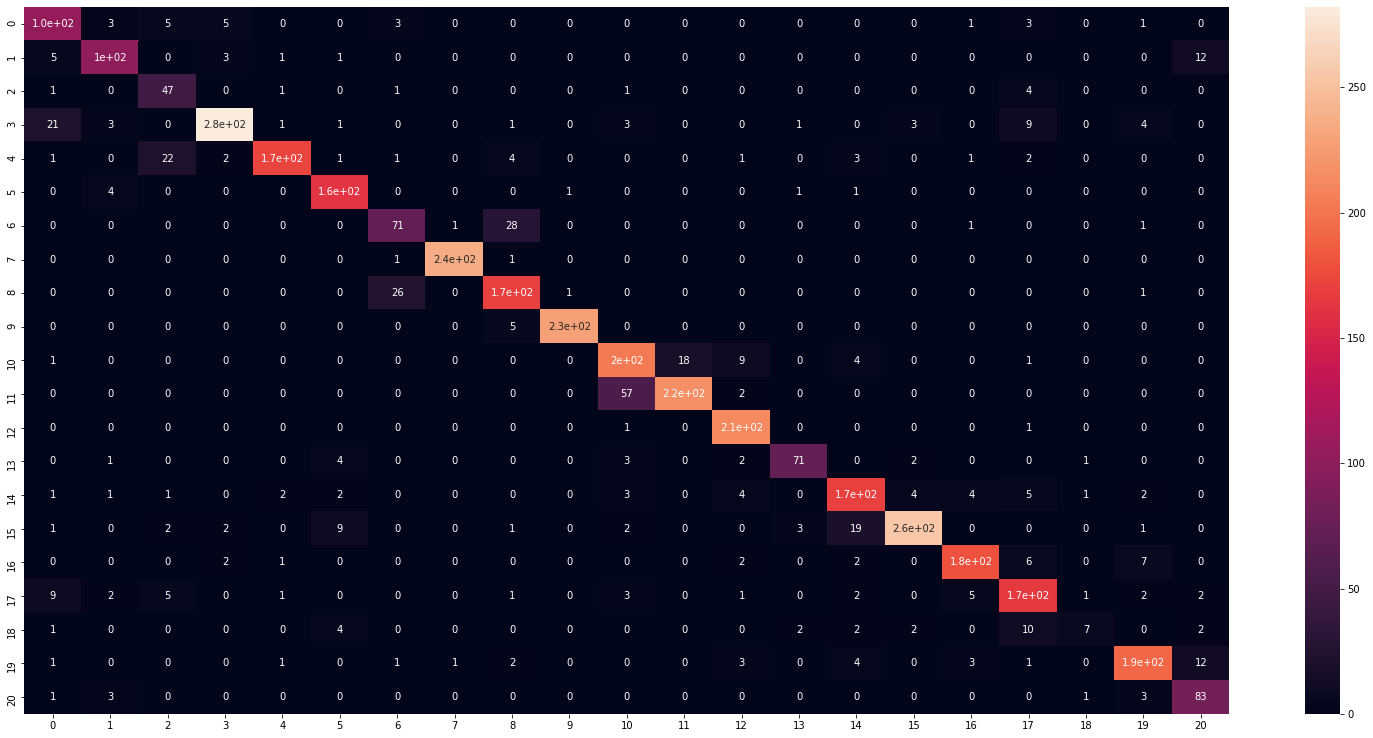

In [25]:
baseline=torch.load('baseline.pt') 
baseline.eval()  
class_acc = Analyze(baseline, test_loader_base)

In [26]:
# Class 별 Accuracy 출력
class_acc

,Label,Accuracy
0,Apple___Cedar_apple_rust,83.333333
1,Cherry___Powdery_mildew,82.258065
2,Corn___healthy,85.454545
3,Corn___Northern_Leaf_Blight,85.714286
4,Corn___Common_rust,81.904762
5,Cherry___healthy,95.882353
6,Apple___Black_rot,69.607843
7,Apple___Apple_scab,99.159664
8,Apple___healthy,85.786802
9,Corn___Cercospora_leaf_spot Gray_leaf_spot,97.844828


전체 예측값의 Accuracy는 86.95로 나온 것을 확인하였다. 이후, 베이스라인 모델을 가지고 예측한 결과의 Classification Report 로 각 class 별 precision, recall, f1score와 예측값의 개수를 시각화한 heatmap, class 별 accuracy를 출력해 보았다. <br>

18번 class인 Grape_Black_rot 질병에 대해서 f1-score 가 0.34로 가장 낮은 것을 확인할 수 있다. precision이 0.64, recall이 0.23인 것으로 보아 예측한 것들 중에서는 정답 비율이 높지만 예측 개수가 작아아서 실제 18번 class의 값들 중에 맞게 예측된 것들의 비율이 낮게 나온 것이라 생각해 볼 수 있다. <br>
반대로, 2번 class인 Corn_Healthy 에 대해  precision이 0.57, recall이 0.85인 것을 보았을 때 해당 class로 넘치게 예측이 되어 True-True는 높은 비율을 보이지만 예측 개수에 비해 정밀도는 떨어지는 것을 유추해 볼 수 있다. <br>
특정 class로 예측을 잘 못 하는, 어떠한 한 class로 예측이 쏠리는 현상이 일어났다고 볼 수 있고, original 데이터의 class 별 imbalance로 인해 생긴 문제점으로 보여진다. 

* Transfer Learning 모델 성능 평가하기

In [21]:
# 기존 데이터로 학습시킨 ResNet

resnet50 = torch.load('resnet.pt') 
resnet50.eval()
test_loss, test_accuracy = evaluate(resnet50, test_loader_base)
print('test acc: ', test_accuracy) # 99.06005221932115

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


test acc:  99.06005221932115


In [24]:
# augmentation 시킨 데이터로 학습시킨 ResNet

resnet50=torch.load('resnet2.pt') 
resnet50.eval()  
test_loss, test_accuracy = evaluate(resnet50, test_loader_resNet['test'])
print('test acc:  ', test_accuracy) # 97.59954078171477

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


test acc:   97.59954078171477


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


              precision    recall  f1-score   support

           0       0.99      0.99      0.99       126
           1       1.00      1.00      1.00       124
           2       1.00      0.96      0.98        55
           3       0.99      1.00      0.99       329
           4       1.00      1.00      1.00       210
           5       1.00      0.99      1.00       170
           6       0.92      0.95      0.94       102
           7       1.00      1.00      1.00       238
           8       0.97      0.95      0.96       197
           9       1.00      1.00      1.00       232
          10       0.98      1.00      0.99       236
          11       1.00      0.98      0.99       276
          12       1.00      1.00      1.00       215
          13       1.00      1.00      1.00        84
          14       0.99      0.98      0.99       199
          15       0.99      0.99      0.99       295
          16       1.00      1.00      1.00       200
          17       0.99    

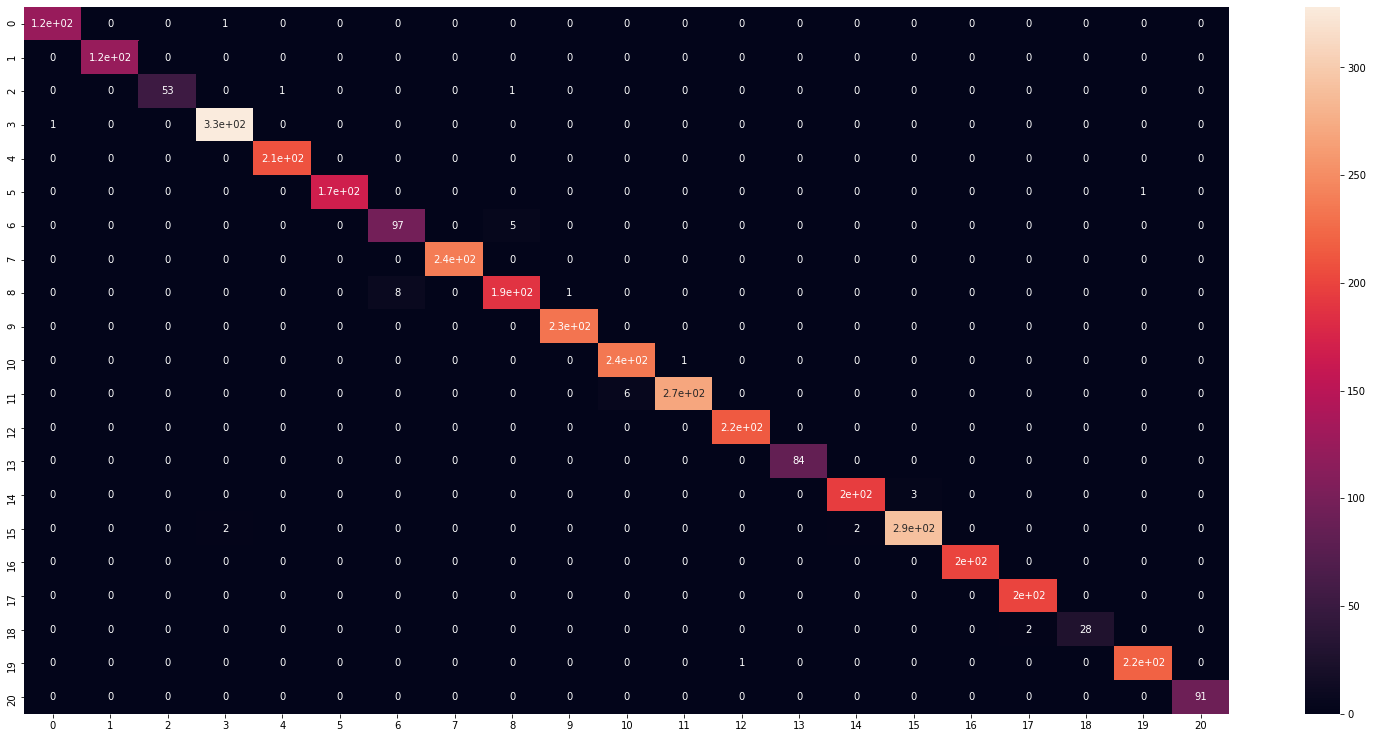

In [27]:
class_acc = Analyze(resnet50, test_loader_base)

In [28]:
class_acc

,Label,Accuracy
0,Apple___Cedar_apple_rust,99.206349
1,Cherry___Powdery_mildew,100.000000
2,Corn___healthy,96.363636
3,Corn___Northern_Leaf_Blight,99.696049
4,Corn___Common_rust,100.000000
5,Cherry___healthy,99.411765
6,Apple___Black_rot,95.098039
7,Apple___Apple_scab,100.000000
8,Apple___healthy,95.431472
9,Corn___Cercospora_leaf_spot Gray_leaf_spot,100.000000


Class 별로 살펴보기 이전에 ResNet50을 transfer learning을 시킨 결과 전체 예측값의 Accuracy가 Baseline보다 10% 이상 증가한 것으로 보아 단편적으로만 보아도 더 성능이 좋다는 것을 확인할 수 있다. <br>
동일하게 Classification Report, Heatmap, Class 별 Accuracy를 출력해 Accuracy, Precision, Recall, F1-score를 살펴 보았을 때 모든 지표에서 100%를 보이는 class들도 확인되었으며, 각 class 별 f1-score 위주로 보았을 때에도(특히 2번과 18번 class) 이전과 달리 data imbalance에 의한 현상은 많이 해결된 것으로 보여진다. 